Subject: Additional Feature Engineering Code Submission.

Date: December 31, 2024.

Dear Professor Ilia Tetin,

I am writing on behalf of our presentation team, which includes two members:



* LE TRAN NHA TRAN - JASMINE (Student ID: 11285100M);
*  DINH VAN LONG - BRAD (Student ID: 11285109M).

Attached below, you will find the new feature we have developed.

dominant_colors_by_brand (Multi-Label Categorical Variable): Identifies the most frequent colors for each brand, allowing for multiple dominant colors per brand.

- Encoding: Instead of just one dominant color per brand, we will use a multi-label encoding scheme where multiple dominant colors can be assigned.
  - 0: This means the color is not dominant (not one of the top colors) for the given brand in that row.
  - 1: This means the color is dominant (one of the top colors) for the given brand in that row.

- Justification: This approach enables us to account for the varying popularity of multiple colors within a single brand.

Thus, we believe multi-label encoding captures the reality that multiple colors can be popular within a single brand, avoiding oversimplification. For instance, Apple’s high demand for both black and gold would be more accurately represented compared to a single-label approach.

In [ ]:
import polars as pl  # Import the Polars library for data manipulation
from sklearn.preprocessing import MultiLabelBinarizer  # Import MultiLabelBinarizer for encoding multiple labels

# Read the cleaned data from a CSV file into a Polars DataFrame
df = pl.read_csv("cleaned_info.csv")

# Fill missing values in the "color" column with "unknown"
df = df.with_columns(pl.col("color").fill_null("unknown"))

# Find the top 2 most popular colors for each brand
top_colors_per_brand = (
    df.group_by("brand", "color")  # Group by brand and color
    .len()  # Count the occurrences
    .sort(["brand", "len"], descending=[False, True])  # Sort by brand and descending count
    .group_by("brand")  # Group again by brand
    .head(2)  # Select the top 2 colors per brand
    .with_columns((pl.col("brand") + "@" + pl.col("color")).alias("brand_color"))  # Create a brand@color identifier
    ["brand_color"]  # Select only the "brand_color" column
    .to_list()  # Convert to a list
)

# Group by brand and aggregate all colors into lists
top_colors = (
    df.with_columns((pl.col("brand") + "@" + pl.col("color")).alias("brand_color"))
    .group_by("brand")  # Group by brand
    .agg(pl.col("brand_color").alias("brand_colors"))  # Aggregate brand colors into lists
    .to_pandas()  # Convert the Polars DataFrame to a pandas DataFrame
)

# Create a mapping dictionary of valid colors per brand
mapping_dict = {}
for brand, colors in zip(top_colors["brand"], top_colors["brand_colors"]):
    valid_colors = []  # Initialize a list to store valid colors
    for entry in colors:
        b, c = entry.split("@")  # Split the "brand@color" identifier
        if entry in top_colors_per_brand:  # Check if the color is among the top colors
            valid_colors.append(c)  # Add the color to the list
    mapping_dict[brand] = valid_colors  # Map the brand to its valid colors

# Prepare a list of lists for MultiLabelBinarizer encoding
encoded_list = []
for brand in df["brand"]:  # Loop through each brand in the DataFrame
    encoded_list.append(mapping_dict[brand])  # Append the corresponding colors

# Use MultiLabelBinarizer to encode the colors
mlb = MultiLabelBinarizer()
encoded_multilabel = mlb.fit_transform(encoded_list)  # Transform the list of lists into a binary matrix

# Add encoded color columns to the Polars DataFrame
for i, color in enumerate(mlb.classes_):  # Loop through the encoded classes
    df = df.with_columns(
        pl.Series(name=f"dominant_color_{color}", values=encoded_multilabel[:, i])  # Create a new column for each color
    )

In [ ]:
df.select(["brand"] + [col for col in df.columns if "dominant_" in col])

brand,dominant_color_black,dominant_color_blue,dominant_color_gold,dominant_color_gray,dominant_color_other,dominant_color_purple,dominant_color_rose_gold,dominant_color_silver,dominant_color_unknown,dominant_color_white
str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
"""Realme""",1,1,0,0,0,0,0,0,0,0
"""Apple""",1,0,1,0,0,0,0,0,0,0
"""Samsung""",1,0,0,0,1,0,0,0,0,0
"""Apple""",1,0,1,0,0,0,0,0,0,0
"""Xiaomi""",1,1,0,0,0,0,0,0,0,0
…,…,…,…,…,…,…,…,…,…,…
"""Apple""",1,0,1,0,0,0,0,0,0,0
"""Google""",1,0,0,0,0,0,0,0,0,1
"""Samsung""",1,0,0,0,1,0,0,0,0,0


- The feature is represented through multiple one-hot encoded columns (e.g., dominant_color_black, dominant_color_blue, etc.), where each column indicates the presence (1) or absence (0) of a specific dominant color for each brand.
- An additional column, dominant_color_unknown, accounts for cases where the color data was originally missing or undefined, ensuring no null values interfere with the analysis.

This categorization ensures that the data is collectively exhaustive (all possible cases are accounted for, including unknowns) and mutually exclusive (each encoded column distinctly represents one color without overlap).

Most brands have black as a common color (dominant_color_black has consistent 1s across rows).

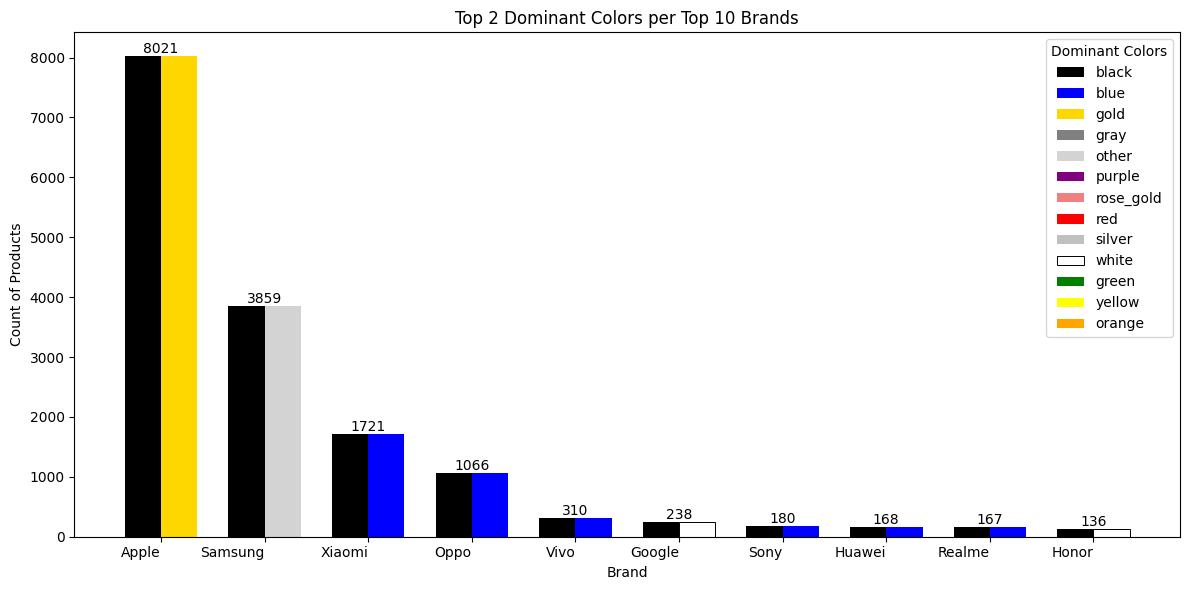

In [ ]:
import polars as pl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

pandas_df = df.to_pandas()

# Identify dominant color columns
dominant_color_cols = [col for col in pandas_df.columns if col.startswith('dominant_color_')]

# Calculate the total number of products per brand
brand_counts = pandas_df['brand'].value_counts().sort_values(ascending=False)

# Get the top 10 brands
top_10_brands = brand_counts.head(10).index.tolist()

# Filter the DataFrame for the top 10 brands
top_10_df = pandas_df[pandas_df['brand'].isin(top_10_brands)]

# Calculate the count of each dominant color per brand for the top 10 brands
color_counts_top_10 = top_10_df.groupby('brand')[dominant_color_cols].sum()

# Reindex color_counts_top_10 to match the order of top_10_brands
color_counts_top_10 = color_counts_top_10.reindex(top_10_brands)

# Determine the top 2 dominant colors for each of the top 10 brands
def get_top_colors(row, n=2):
    """Returns the names and counts of the top N dominant colors."""
    top_n_indices = row.nlargest(n).index
    top_n_colors = [idx.replace("dominant_color_", "") for idx in top_n_indices]
    top_n_counts = row.nlargest(n).values
    return list(zip(top_n_colors, top_n_counts))

color_counts_top_10['top_colors'] = color_counts_top_10.apply(get_top_colors, axis=1)

# Define a color map for the bars
color_map = {
    "black": "black",
    "blue": "blue",
    "gold": "gold",
    "gray": "gray",
    "other": "lightgray",  # A lighter shade of gray
    "purple": "purple",
    "rose_gold": "lightcoral",
    "red": "red",
    "silver": "silver",
    "white": "white",
    "green": "green",
    "yellow": "yellow",
    "orange": "orange"
}

# Create the grouped bar chart for the top 10 brands
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.35
index = np.arange(len(color_counts_top_10))

for i, row in enumerate(color_counts_top_10['top_colors']):
    for j, (color_name, count) in enumerate(row):
        color = color_map.get(color_name, 'gray')
        position = index[i] + j * bar_width
        edgecolor = 'black' if color_name == 'white' else None
        ax.bar(position, count, bar_width, label=color_name if i == 0 else "", color=color, edgecolor=edgecolor, linewidth=0.7)
        if j == 0:
            ax.text(position + bar_width / 2, count, str(int(count)), ha='center', va='bottom')

ax.set_xlabel("Brand")
ax.set_ylabel("Count of Products")
ax.set_title("Top 2 Dominant Colors per Top 10 Brands")
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(color_counts_top_10.index, rotation=0, ha='right')
# Create legend handles and labels
handles = [plt.Rectangle((0, 0), 1, 1, facecolor=color_map.get(label, 'gray'), edgecolor='black' if label == 'white' else None, linewidth=0.7) for label in color_map]
labels = color_map.keys()
ax.legend(handles, labels, title="Dominant Colors")
plt.tight_layout()
plt.show()

In this case:
1. Brand Preference:

The "brand" column indicates multiple brands in the dataset, such as "Realme", "Apple", "Samsung", etc., suggesting the dataset covers diverse manufacturers.

- Apple is the most popular brand, with a significantly higher count of products compared to others, suggesting strong consumer demand for second-hand Apple devices.
- Samsung follows Apple in popularity, but the count of products is much lower than Apple.
- Xiaomi and Oppo also have notable demand but are far less popular than Apple and Samsung.
2. Color Preference:

- For Apple devices, black and yellow (gold) dominate, indicating a preference for these colors among consumers.
Samsung shows strong demand for black and silver, which could reflect a preference for neutral and professional-looking devices.
- Other brands like Xiaomi and Oppo highlight blue and black as popular choices, suggesting that more vibrant colors appeal to consumers of these brands.
- Google phones, while relatively niche, have a decent representation of second-hand listings with white as a dominant color.

3. Consumer Behavior Trends:

- The dominance of certain colors (e.g., black, gold) across multiple brands suggests a general consumer preference for basic, timeless and versatile colors.
- Apple’s overwhelming popularity might indicate that Vietnamese consumers see value in Apple’s branding, quality, and resale value, even in the second-hand market. However, in the near future, the stark difference in product counts between Apple and other brands suggests a saturated second-hand Apple market but also an opportunity for growth for brands like Samsung, Xiaomi, and Oppo.
- Lesser-demand brands might have untapped potential by targeting niche audiences with competitive pricing or unique features.

Thus,
- Black as a Popular Color:
Black seems to be a common color across multiple brands, appearing in every row in the table. This might reflect its universal appeal.
- Color Exclusivity:
Certain colors, like "rose_gold" and "purple," appear less frequently, suggesting they are niche or limited to specific brands (e.g., Apple).
- Unknown Dominance:
No rows in the provided sample have dominant_color_unknown as 1. This suggests that the missing data has already been mitigated for this subset or that unknown values are rare.

1. Consumer Behavior Insights:
  - Black and white colors seem to dominate across brands, likely reflecting their neutrality and appeal to most users.
  - Less common colors (e.g., purple, rose_gold) may indicate a niche market or exclusive designs.
2. Strategic Implications for Brands:

  - Brands like Samsung and Google with more diverse colors can target wider audiences.
  - Brands like Apple focusing on fewer, premium colors can position themselves as exclusive.
3. Opportunities for Business Expansion:

  - Brands like Realme with limited color options might explore adding diverse colors to compete with brands offering variety.